In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import scipy.stats as stats
import seaborn as sns
# import multiprocessing

sns.set(style='ticks', color_codes = True)

# Reading in data

In [11]:
# song features
songfeat_mean = pd.read_csv('songfeatures_filteragg_mean.csv', sep=",")
songfeat_median = pd.read_csv('songfeatures_filteragg_median.csv', sep=",")

# ticket features
ticket_mean = pd.read_csv('seatgeek_ticket_filteragg_mean.csv', sep=",")
ticket_median = pd.read_csv('seatgeek_ticket_filteragg_median.csv', sep=",")

# Shape info
print(songfeat_mean.shape)
print(songfeat_median.shape)

print(ticket_mean.shape)
print(ticket_median.shape)

(5345, 12)
(5345, 12)
(4557, 28)
(4557, 28)


In [13]:
songfeat_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345 entries, 0 to 5344
Data columns (total 12 columns):
artist              5345 non-null object
track_number        5345 non-null float64
acousticness        5345 non-null float64
danceability        5345 non-null float64
energy              5345 non-null float64
instrumentalness    5345 non-null float64
liveness            5345 non-null float64
loudness            5345 non-null float64
speechiness         5345 non-null float64
tempo               5345 non-null float64
valence             5345 non-null float64
popularity          5345 non-null float64
dtypes: float64(11), object(1)
memory usage: 501.2+ KB


In [36]:
# songfeat_mean[songfeat_mean['artist'].str.contains('maniacs')]

,artist,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
2734,Los Texmaniacs,8.061947,0.390473,0.656106,0.632513,0.090226,0.152989,-7.744088,0.084919,129.153655,0.779832,5.672566


In [14]:
ticket_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4557 entries, 0 to 4556
Data columns (total 28 columns):
performers_name                          4557 non-null object
performers_id                            4557 non-null int64
enddatetime_utc                          0 non-null float64
id                                       4557 non-null float64
performers_num_upcoming_events           4557 non-null float64
performers_popularity                    4557 non-null float64
performers_score                         4557 non-null float64
popularity                               4557 non-null float64
score                                    4557 non-null float64
stats_average_price                      4557 non-null float64
stats_highest_price                      4557 non-null float64
stats_listing_count                      4557 non-null float64
stats_lowest_price                       4557 non-null float64
stats_lowest_price_good_deals            1482 non-null float64
stats_lowest_sg_b

# Merging the Ticket and Music Data

In [27]:
mean_df = pd.merge(ticket_mean, songfeat_mean, right_on='artist', left_on='performers_name', how='left')
mean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4557 entries, 0 to 4556
Data columns (total 40 columns):
performers_name                          4557 non-null object
performers_id                            4557 non-null int64
enddatetime_utc                          0 non-null float64
id                                       4557 non-null float64
performers_num_upcoming_events           4557 non-null float64
performers_popularity                    4557 non-null float64
performers_score                         4557 non-null float64
popularity_x                             4557 non-null float64
score                                    4557 non-null float64
stats_average_price                      4557 non-null float64
stats_highest_price                      4557 non-null float64
stats_listing_count                      4557 non-null float64
stats_lowest_price                       4557 non-null float64
stats_lowest_price_good_deals            1482 non-null float64
stats_lowest_sg_b

In [28]:
mean_df

,performers_name,performers_id,enddatetime_utc,id,performers_num_upcoming_events,performers_popularity,performers_score,popularity_x,score,stats_average_price,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity_y
0,!!! (Chk Chk Chk),22271,NaN,4.909388e+06,6.000000,0.0,0.390000,0.269000,0.202200,70.200000,...,0.082692,0.746218,0.774124,2.808613e-01,0.178466,-7.689427,0.078385,120.291973,0.613115,22.372727
1,(Sandy) Alex G,288439,NaN,4.977232e+06,5.000000,0.0,0.520000,0.211500,0.220000,64.500000,...,0.436583,0.518501,0.507272,4.076341e-01,0.160320,-9.047859,0.039868,120.990370,0.411405,37.695652
2,070 Shake,610195,NaN,4.972756e+06,18.769231,0.0,0.456923,0.305000,0.302000,97.384615,...,0.287187,0.693765,0.504647,9.187244e-03,0.166871,-8.579529,0.101606,120.564647,0.298753,46.588235
3,"10,000 Maniacs",9158,NaN,4.971112e+06,5.000000,0.0,0.432500,0.310500,0.299750,96.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106.9 The Fox,705367,NaN,4.958432e+06,2.000000,0.0,0.400000,0.419333,0.410333,80.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,112,16858,NaN,4.964795e+06,1.000000,0.0,0.500000,0.260000,0.242000,194.000000,...,0.235635,0.621328,0.537148,3.034816e-04,0.170666,-8.399313,0.081848,110.526211,0.542398,23.585938
6,12th Planet,7548,NaN,4.969690e+06,2.000000,0.0,0.470000,0.381000,0.378000,86.000000,...,0.006144,0.562826,0.928348,2.344230e-01,0.272111,-2.725152,0.213448,127.152543,0.235948,27.478261
7,1349,247021,NaN,4.981462e+06,10.000000,0.0,0.390000,0.185500,0.150000,70.500000,...,0.046970,0.254826,0.864070,4.812508e-01,0.350721,-7.405485,0.105506,120.060192,0.162683,9.584615
8,1788-L,689651,NaN,4.979279e+06,2.000000,0.0,0.680000,0.380000,0.360000,366.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1964 The Tribute,2231,NaN,4.923804e+06,3.000000,0.0,0.470000,0.000000,0.000000,84.000000,...,0.072593,0.496805,0.604732,4.224634e-02,0.470163,-9.935341,0.036434,134.004268,0.758854,0.731707


In [29]:
median_df = pd.merge(ticket_mean, songfeat_mean, right_on='artist', left_on='performers_name', how='left')
median_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4557 entries, 0 to 4556
Data columns (total 40 columns):
performers_name                          4557 non-null object
performers_id                            4557 non-null int64
enddatetime_utc                          0 non-null float64
id                                       4557 non-null float64
performers_num_upcoming_events           4557 non-null float64
performers_popularity                    4557 non-null float64
performers_score                         4557 non-null float64
popularity_x                             4557 non-null float64
score                                    4557 non-null float64
stats_average_price                      4557 non-null float64
stats_highest_price                      4557 non-null float64
stats_listing_count                      4557 non-null float64
stats_lowest_price                       4557 non-null float64
stats_lowest_price_good_deals            1482 non-null float64
stats_lowest_sg_b

In [30]:
median_df

,performers_name,performers_id,enddatetime_utc,id,performers_num_upcoming_events,performers_popularity,performers_score,popularity_x,score,stats_average_price,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity_y
0,!!! (Chk Chk Chk),22271,NaN,4.909388e+06,6.000000,0.0,0.390000,0.269000,0.202200,70.200000,...,0.082692,0.746218,0.774124,2.808613e-01,0.178466,-7.689427,0.078385,120.291973,0.613115,22.372727
1,(Sandy) Alex G,288439,NaN,4.977232e+06,5.000000,0.0,0.520000,0.211500,0.220000,64.500000,...,0.436583,0.518501,0.507272,4.076341e-01,0.160320,-9.047859,0.039868,120.990370,0.411405,37.695652
2,070 Shake,610195,NaN,4.972756e+06,18.769231,0.0,0.456923,0.305000,0.302000,97.384615,...,0.287187,0.693765,0.504647,9.187244e-03,0.166871,-8.579529,0.101606,120.564647,0.298753,46.588235
3,"10,000 Maniacs",9158,NaN,4.971112e+06,5.000000,0.0,0.432500,0.310500,0.299750,96.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106.9 The Fox,705367,NaN,4.958432e+06,2.000000,0.0,0.400000,0.419333,0.410333,80.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,112,16858,NaN,4.964795e+06,1.000000,0.0,0.500000,0.260000,0.242000,194.000000,...,0.235635,0.621328,0.537148,3.034816e-04,0.170666,-8.399313,0.081848,110.526211,0.542398,23.585938
6,12th Planet,7548,NaN,4.969690e+06,2.000000,0.0,0.470000,0.381000,0.378000,86.000000,...,0.006144,0.562826,0.928348,2.344230e-01,0.272111,-2.725152,0.213448,127.152543,0.235948,27.478261
7,1349,247021,NaN,4.981462e+06,10.000000,0.0,0.390000,0.185500,0.150000,70.500000,...,0.046970,0.254826,0.864070,4.812508e-01,0.350721,-7.405485,0.105506,120.060192,0.162683,9.584615
8,1788-L,689651,NaN,4.979279e+06,2.000000,0.0,0.680000,0.380000,0.360000,366.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1964 The Tribute,2231,NaN,4.923804e+06,3.000000,0.0,0.470000,0.000000,0.000000,84.000000,...,0.072593,0.496805,0.604732,4.224634e-02,0.470163,-9.935341,0.036434,134.004268,0.758854,0.731707


In [ ]:
focus

# MEAN-EDA

## 1. What's the relationship between streamming popularity and average ticket price?

Text(0, 0.5, 'Streaming Popularity')

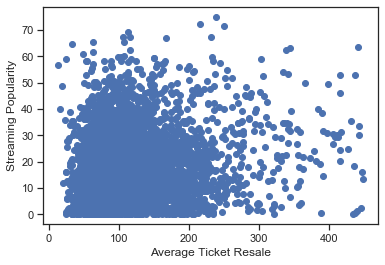

In [40]:
plt.scatter(mean_df['stats_average_price'], mean_df['popularity_y']);
plt.xlabel('Average Ticket Resale')
plt.ylabel('Streaming Popularity')

In [41]:
mean_df['stats_average_price'].corr(mean_df['popularity_y'])

0.11806715987618462

There is small, positive correlation between streamming popularity and average resale price.